In [1]:
from __future__ import print_function
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import png
import matplotlib.pyplot as plt
#import sklearn

import ee
#import ee.mapclient
from IPython.display import Image
import IPython.display as display

ee.Initialize()

In [2]:
tf.disable_v2_behavior()
try:
    tf.enable_eager_execution()
except Exception:
    pass

Instructions for updating:
non-resource variables are not supported in the long term


In [25]:
## Import data set from as TFRecord files

filenames_train = []
no_files_train = 10

for i in range(no_files_train):
    filenames_train.append("../data/EE_data/EE_data_training/train_patches_"+"{0:04}".format(i)+".tfrecord")
    
#print(filenames_train)
dataset_train = tf.data.TFRecordDataset(filenames_train)

for raw_record in dataset_train.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "B11"
    value {
      float_list {
        value: 0.1964624971151352
        value: 0.1970124989748001
        value: 0.19628749787807465
        value: 0.19616875052452087
        value: 0.1966562420129776
        value: 0.19871875643730164
        value: 0.2023562490940094
        value: 0.19783750176429749
        value: 0.1979375034570694
        value: 0.19636249542236328
        value: 0.19580624997615814
        value: 0.19626875221729279
        value: 0.19795624911785126
        value: 0.20086875557899475
        value: 0.19865624606609344
        value: 0.1978749930858612
        value: 0.19542500376701355
        value: 0.1946687549352646
        value: 0.19560624659061432
        value: 0.1973312497138977
        value: 0.19984374940395355
        value: 0.19891874492168427
        value: 0.19682499766349792
        value: 0.19347499310970306
        value: 0.19275625050067902
        value: 0.1946687549352646
        value: 0.1968437433242

In [26]:
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
label_names = ['vegetation_elementstree_element_cover_label', \
                'vegetation_elementsshrub_element_cover_label', \
                'vegetation_elementspalm_element_cover_label', \
                'vegetation_elementsbamboo_element_cover_label', \
                'vegetation_elementscrop_element_cover_label', \
                'infrastructure_elementshouse_element_cover_label', \
                'infrastructure_elementsother_buildings_element_cover_label', \
                'infrastructure_elementspaved_road_element_cover_label', \
                'infrastructure_elementsunpaved_road_element_cover_label', \
                'water_bodieslake_water_cover_label', \
                'water_bodiesriver_water_cover_label', \
                'total_water_bodies_cover_label'];

featureDict = {
  'public_id': tf.io.FixedLenFeature(shape=[1], dtype=tf.string),
  'B2': tf.io.FixedLenFeature(shape=[7,7], dtype=tf.float32),
  'B3': tf.io.FixedLenFeature(shape=[7,7], dtype=tf.float32),
  'B4': tf.io.FixedLenFeature(shape=[7,7], dtype=tf.float32),
  'B5': tf.io.FixedLenFeature(shape=[7,7], dtype=tf.float32),
  'B6': tf.io.FixedLenFeature(shape=[7,7], dtype=tf.float32),
  'B7': tf.io.FixedLenFeature(shape=[7,7], dtype=tf.float32),
  'B8': tf.io.FixedLenFeature(shape=[7,7], dtype=tf.float32),
  'B8A': tf.io.FixedLenFeature(shape=[7,7], dtype=tf.float32),
  'B11': tf.io.FixedLenFeature(shape=[7,7], dtype=tf.float32),
  'B12': tf.io.FixedLenFeature(shape=[7,7], dtype=tf.float32),
  'vegetation_elementstree_element_cover_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.float32),
  'vegetation_elementsshrub_element_cover_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.float32),
  'vegetation_elementspalm_element_cover_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.float32),
  'vegetation_elementsbamboo_element_cover_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.float32),
  'vegetation_elementscrop_element_cover_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.float32),
  'infrastructure_elementshouse_element_cover_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.float32),
  'infrastructure_elementsother_buildings_element_cover_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.float32),
  'infrastructure_elementspaved_road_element_cover_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.float32),
  'infrastructure_elementsunpaved_road_element_cover_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.float32),
  'water_bodieslake_water_cover_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.float32),
  'water_bodiesriver_water_cover_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.float32),
  'total_water_bodies_cover_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.float32)
}

In [27]:
## Parse TFRecord dataset

def _parse_function(example):
  # Parse the input `tf.Example` proto using the dictionary above.
  return tf.io.parse_example(example, featureDict)

#batches = dataset_train.batch(10, drop_remainder=True)
#parsedDataset_train = batches.map(_parse_function)

parsedDataset_train = dataset_train.map(_parse_function)

#print(parsedDataset_train)

for i, parsed_record in enumerate(parsedDataset_train.take(10)):
    print(i)
    #print(repr(parsed_record))
    

0
1
2
3
4
5
6
7
8
9


In [28]:
## Create Sentinel composite image

# Function to mask clouds using the Sentinel-2 QA band
# @param ee.Image image Sentinel-2 image
# @return ee.Image cloud masked Sentinel-2 image
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
      .And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

def maskS2val(image):
    return image.divide(10000)

## Function to resample bands to 10m per pixel
# @param ee.Image image Sentinel-2 image with 10m and 20m resolution
# @return ee.Image cloud masked Sentinel-2 image with 10m resolution
#TBD: generalize
def resample_bands(image):
    img_res = image.select(bands_10m)
    for i in range(len(bands_20m)):
        band = bands_20m[i]
        img_res = img_res.addBands(image.select(band) \
          .resample('bilinear') \
          .reproject( \
            crs=image.select(bands_20m[i]).projection().crs(), \
            scale=10))
    return img_res



## Load Sentinel-2 TOA reflectance data and mask clouds
sentinel2_collection = ee.ImageCollection('COPERNICUS/S2') \
                    .filterDate('2016-05-01', '2016-12-01') \
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 80)) \
                    .map(maskS2val)
#                    .map(maskS2clouds)

## Use these bands for prediction
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
#sentinel2_collection = sentinel2_collection.select(bands)
bands_10m = ['B2', 'B3', 'B4', 'B8']
bands_20m = ['B5', 'B6', 'B7', 'B8A', 'B11', 'B12']

#sentinel2_resampled = sentinel2_collection
sentinel2_resampled = sentinel2_collection.map(resample_bands)

## Create the composite image
sentinel2_composite = sentinel2_resampled.min()

In [8]:
## Read in labeled data to check data and to match location with public_id

labeled_dataset_df = pd.read_csv("../data/FAO_data_clean_subset_Dao.csv")
labeled_dataset_df.head()

/Users/rotti/.conda/envs/ee/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,public_id,location_x,location_y,actively_saved_on_year,actively_saved_on_month,actively_saved_on_day,land_use_category,rs_date_year,rs_date_month,rs_date_day,...,vegetation_elementspalm_element_cover_label,vegetation_elementsbamboo_element_cover_label,vegetation_elementscrop_element_cover_label,infrastructure_elementshouse_element_cover_label,infrastructure_elementsother_buildings_element_cover_label,infrastructure_elementspaved_road_element_cover_label,infrastructure_elementsunpaved_road_element_cover_label,water_bodieslake_water_cover_label,water_bodiesriver_water_cover_label,total_water_bodies_cover_label
0,GLU0476368,-72.334750,-2.772338,2016,8,15,forest,NaN,NaN,NaN,...,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1,GLU0476367,-72.476469,-2.760354,2016,8,18,forest,NaN,NaN,NaN,...,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
2,GLU0476366,-71.887154,-2.515346,2016,8,15,forest,NaN,NaN,NaN,...,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
3,GLU0476365,-72.028673,-2.503777,2016,8,17,wetland,NaN,NaN,NaN,...,0%,0%,0%,0%,0%,0%,0%,0%,90-100%,90-100%
4,GLU0476364,-71.876029,-2.369105,2016,8,11,forest,NaN,NaN,NaN,...,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%


GLU0341929
[0.]


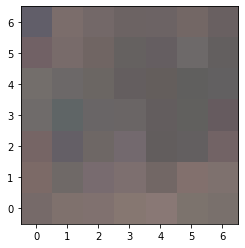

In [14]:
## Display extracted TFRecord data

# Select one example for inspection
parsed_example = parsedDataset_train.take(1000)
#print(parsed_example)
    
# Extract RGB data for example from TF data
for example in parsed_example:
    public_id = example['public_id'].numpy()
    public_id = public_id[0].decode("utf-8")
    tree_cover = example['vegetation_elementstree_element_cover_label'].numpy()  
    if public_id == 'GLU0341929':
        print(public_id)
        print(tree_cover)
        #print(tree_cover)
        B4 = example['B4'].numpy()
        B3 = example['B3'].numpy()
        B2 = example['B2'].numpy()
        #print(B4, B3, B2)
        rgbArray = np.zeros((7,7,3))
        rgbArray[..., 0] = B4
        rgbArray[..., 1] = B3
        rgbArray[..., 2] = B2
        rgbArray[rgbArray > 0.3] = 0.3
        rgbArray = rgbArray / 0.3
        #print(rgbArray)

plt.imshow(rgbArray, origin='lower')


GLU0341929
-43.073614
-7.982160941


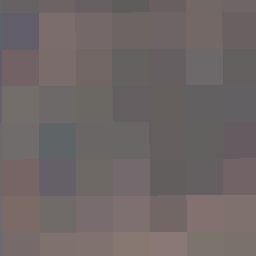

In [29]:
## Display original Sentinel2 data

# Match public_id of example entries with ground truth data and extract coordinates
#for example in parsed_example:
#    public_id = example['public_id'].numpy()
#    public_id = public_id[0].decode("utf-8") 
    
public_id = 'GLU0341929'

row = labeled_dataset_df.loc[labeled_dataset_df['public_id'] == public_id]
x = row.iloc[0]['location_x']
y = row.iloc[0]['location_y']
print(public_id)
print(x)
print(y)
        
        
# Generate region to display
roi = ee.Geometry.Point([x, y]).buffer(35).bounds()

# Display the image in the notebook.
Image(url=sentinel2_composite.getThumbUrl({'min': 0, 'max': 0.3,
                                           'dimensions': 256,
                                           'bands': ['B4', 'B3', 'B2'],
                                           'region': roi}),
      format='png', embed=True)

GLU0340923
[0.]


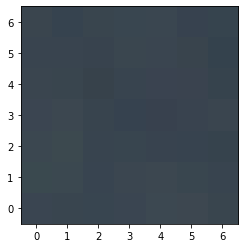

In [40]:
## Display extracted TFRecord data

# Select one example for inspection
parsed_example = parsedDataset_train.take(1000)
#print(parsed_example)
    
# Extract RGB data for example from TF data
for example in parsed_example:
    public_id = example['public_id'].numpy()
    public_id = public_id[0].decode("utf-8")
    tree_cover = example['vegetation_elementstree_element_cover_label'].numpy()  
    if public_id == 'GLU0340923':
        print(public_id)
        print(tree_cover)
        B4 = example['B4'].numpy()
        B3 = example['B3'].numpy()
        B2 = example['B2'].numpy()
        #print(B4, B3, B2)
        rgbArray = np.zeros((7,7,3))
        rgbArray[..., 0] = B4
        rgbArray[..., 1] = B3
        rgbArray[..., 2] = B2
        rgbArray[rgbArray > 0.3] = 0.3
        rgbArray = rgbArray / 0.3
        #print(rgbArray)

plt.imshow(rgbArray, origin='lower')



GLU0476352
-61.916081999999996
-0.776224


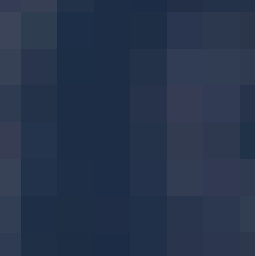

In [41]:
## Display original Sentinel2 data for a given public_id 
    
public_id = 'GLU0476352'
#public_id = 'GLU0471130'
#public_id = 'GLU0458215'
#public_id = 'GLU0341929'
#public_id = 'GLU0340923'

row = labeled_dataset_df.loc[labeled_dataset_df['public_id'] == public_id]
x = row.iloc[0]['location_x']
y = row.iloc[0]['location_y']
print(public_id)
print(x)
print(y)
        
        
# Generate region to display
roi = ee.Geometry.Point([x, y]).buffer(35).bounds()

# Display the image in the notebook.
Image(url=sentinel2_composite.getThumbUrl({'min': 0, 'max': 0.3,
                                           'dimensions': 256,
                                           'bands': ['B4', 'B3', 'B2'],
                                           'region': roi}),
      format='png', embed=True)

40-49%
GLU0476352
-61.916081999999996
-0.776224


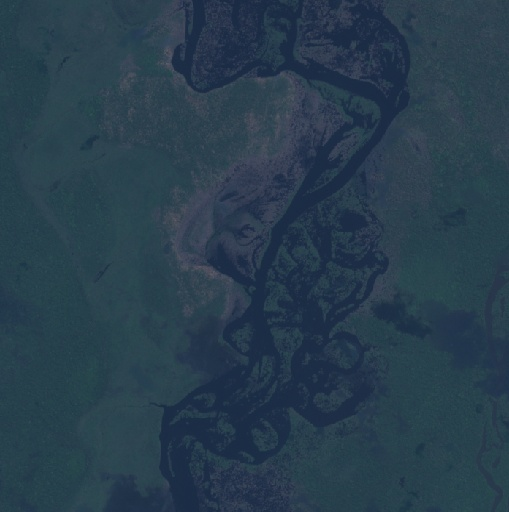

In [42]:
## Display more context for a given public_id

public_id = 'GLU0476352'
#public_id = 'GLU0471130'

row = labeled_dataset_df.loc[labeled_dataset_df['public_id'] == public_id]
x = row.iloc[0]['location_x']
y = row.iloc[0]['location_y']
tree_cover = row.iloc[0]['vegetation_elementstree_element_cover_label']
print(tree_cover)
print(public_id)
#print(row)
print(x)
print(y)
        
        
# Generate region to display
roi = ee.Geometry.Point([x, y]).buffer(3500).bounds()

# Display the image in the notebook.
Image(url=sentinel2_composite.getThumbUrl({'min': 0, 'max': 0.3,
                                           'dimensions': 512,
                                           'bands': ['B4', 'B3', 'B2'],
                                           'region': roi}),
      format='png', embed=True)